In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [3]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2020-10-15,15330.50,14937.50,15073.12,80.30,1213709.55,15241.70,direct,
2020-10-16,15324.62,14863.55,15241.70,98.89,1485526.61,14983.81,direct,
2020-10-17,15081.74,14914.33,14983.81,46.86,701943.21,15001.28,direct,
2020-10-18,15231.54,14989.99,15001.28,35.62,538208.94,15223.00,direct,
2020-10-19,15565.79,15063.88,15223.00,72.08,1106948.25,15536.10,direct,


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)

In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

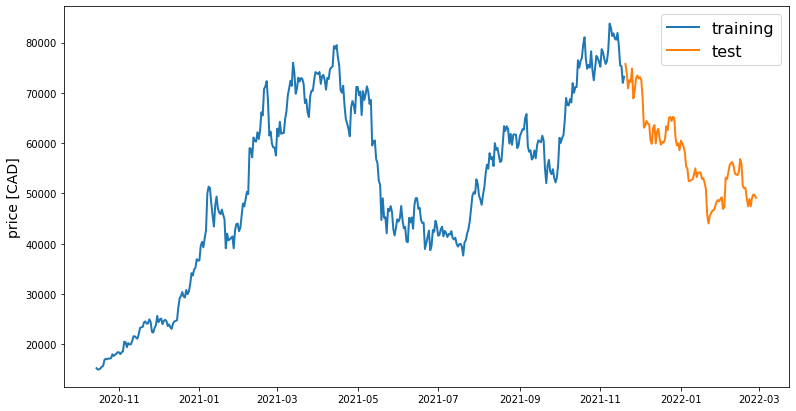

In [6]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [7]:
def normalise_zero_base(df):
    window_df = np.array(df.values[:,0:6])
    max_df = np.array(df.iloc[0].values[0:6])
    return window_df / max_df

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [8]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp)
    return np.array(window_data)

In [9]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [10]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [11]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 40
batch_size = 16
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [12]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32'), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/40
25/25 [==============================] - 1s 3ms/step - loss: 0.0238
Epoch 2/40
25/25 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 3/40
25/25 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 4/40
25/25 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 5/40
25/25 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6/40
25/25 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 7/40
25/25 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 8/40
25/25 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 9/40
25/25 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 10/40
25/25 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 11/40
25/25 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 12/40
25/25 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 13/40
25/25 [==============================

In [15]:
targets = test[target_col][window_len:]
preds = model.predict(np.asarray(X_test).astype('float32')).squeeze()
mean_absolute_error(preds, y_test)

0.037391529767837856

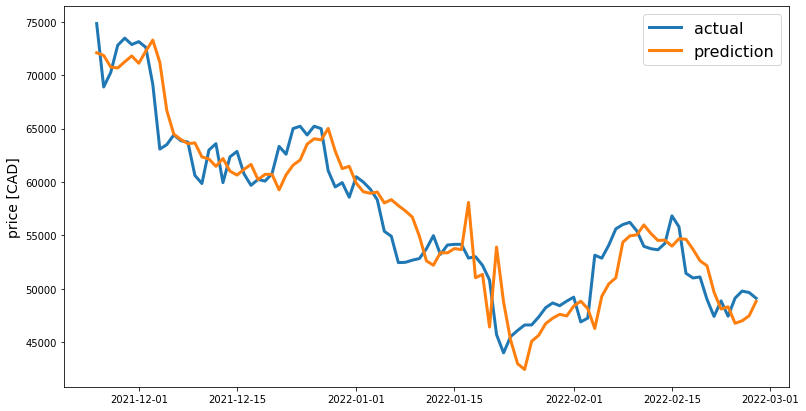

In [16]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)
plt.savefig("prediction with 20% test, 40 epochs")